A fictional power system consists of conventional power plants, renewable energy sources (wind & solar) and consumers. It is necessary to schedule optimal levels of conventional production such that the energy supply meets demand ($d_t$), only a certain deviation, $\Delta$, is accepted from the perfect balancing. Futhermore, probability of excess deviation (i.e. larger than $\Delta$) cannot be higher than ($\varepsilon$).

We simulate process of planning levels of power generation in the conventional plants one hour in advance. They must be within a range $pmin$ and $pmax$, specific to each generator. It is possible to shut down a generator, it is associated with (<i>shut-down cost</i>, $SDC$), just as its start-up is with (<i>start-up cost</i>, $SUC$) (both specific to each generator). The decision to shut down or start up a generator is made 2 hours in advance (<i>ramp time</i>). If a generator is on, it involves fixed costs ($FC$) and operational (marginal) costs ($MC$).

To determine the optimal total production we use short-term energy demand forecasts ($d_t^*$) as well as forecasts of wind ($ {wind}_{t}^*$) and solar generation ($ solar_{t}^*$)
&nbsp;&nbsp;&nbsp;&nbsp; $ p_{conv} = d_t^* - {wind}_{t}^* - solar_{t}^* $

The above quantity is then distributed across available generators in a process called economic dispatch.

<b>Decision variables:</b> 

* $ p_{i,t} $ - scheduled generation of $i$ th generator at hour $t$
* $ I_{i,t}$ - binary variable: is $i$ th generator working at hour $t$ <br><br>

<b>Objective:</b> 

&nbsp;&nbsp;&nbsp;&nbsp; $ \min \ \sum_{i=1}^{N}(I_{i,t} \cdot FC_i + MC_i \cdot p_{i,t} + shut_{i,t} \cdot SDC_i + start_{i,t} \cdot SUC_i) $ <br><br>

<b>Constraints:</b>

$ (1) \ \ \ \mathbb{P} (wind_t + solar_t + \sum_{i=1}^{N} p_{i,t} \ > \ d_t + \Delta) \ \le \ \varepsilon $ <br>
$ (2) \ \ \ \mathbb{P} (wind_t + solar_t + \sum_{i=1}^{N} p_{i,t} \ < \ d_t - \Delta) \ \le \ \varepsilon $ <br>
$ (3) \ \ \ I_{i,t} \cdot pmin_i \le p_{i,t} \le I_{i,t} \cdot pmax_i $ <br>


gdzie:<br>
$d_t$ - actual demand at $t$<br>
$shut_{i,t}$, $start_{i,t}$ - shut-down or start-up at $t$,<br>

&nbsp;&nbsp;&nbsp;&nbsp;$shut_{i,t}$ = 1 when $I_{i,t-1}=1$ i $I_{i,t}=0$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;$start_{i,t}$ = 1 when $I_{i,t-1}=0$ i $I_{i,t}=1$ <br>

We consider 7 conventional generators:

In [2]:
using DataFrames, CSV
plants = DataFrame(CSV.File("power-plants.csv"))

Row,Plant,Capacity,Min_generation,Fixed_cost,Operating_cost,Startup_cost,Shutdown_cost
,String1,Int64,Int64,Int64,Int64,Int64,Int64
1,A,24092,11628,9652,482,533547,63090
2,B,13517,5584,5030,502,420725,56606
3,C,2112,126,2719,431,235801,28669
4,D,25349,13111,4980,479,557077,71323
5,E,18635,3995,4235,498,544392,92052
6,F,7131,415,3806,410,114108,19455
7,G,9506,728,3933,516,289181,32020


### Data

In [3]:
using Plots, GLM, StatsModels, Statistics, Distributions, HypothesisTests

In [4]:
# time series 
ts = DataFrame(CSV.File("time-series.csv"))
summary(ts)

"50393×5 DataFrame"

Source of sample time series data: Open Power System Data (2020). Published online: https://open-power-system-data.org/ [accessed 2023-05-22].

In [36]:
describe(ts)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,load_actual,55494.7,31307,55093.0,77549,0,Int64
2,load_forecast_1h,55376.7,29129.5,55319.2,76716.7,0,Float64
3,load_forecast_2h,54795.9,28824,54739.0,75912,0,Int64
4,solar,2644.97,0.0,98.4906,17357.1,0,Float64
5,wind,2959.81,28.56,2347.83,11421.3,0,Float64


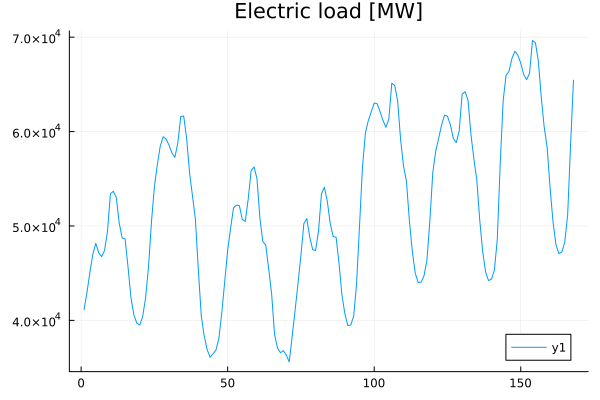

In [5]:
plot(ts[1:24*7,:load_actual],title="Electric load [MW]")


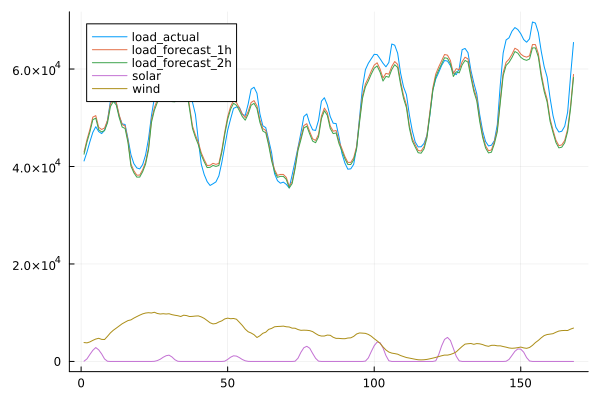

In [38]:
plot(Matrix(ts[1:24*7,:]), labels = permutedims(names(ts)))

In [6]:
d_conv = ts[!,:load_actual]-ts[!,:solar]-ts[!,:wind]
println("In ",round(sum(d_conv .< 0)/size(ts)[1]*100;digits=2),"% of cases renewables generation surpassed total demand.")

In 0.0% of cases renewables generation surpassed total demand.


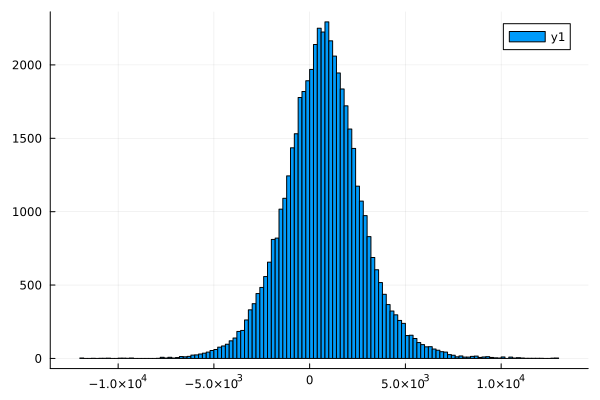

In [40]:
errors2h = ts[!,:load_actual]-ts[!,:load_forecast_2h]
histogram(errors2h)

In [7]:
kstest = ExactOneSampleKSTest(errors, Normal(mean(errors), std(errors)))
kspval = pvalue(kstest)
if kspval > 0.05
    println("Not rejecting null hypothesis (distribution is normal)")
else
    println("Reject null - distribution is not normal")
end

UndefVarError: UndefVarError: errors not defined

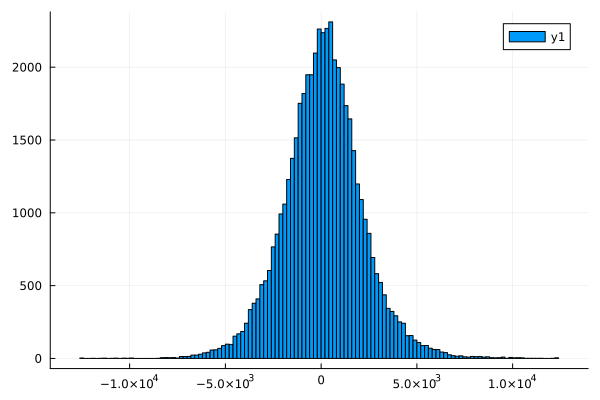

In [42]:
errors1h = ts[!,:load_actual]-ts[!,:load_forecast_1h]
histogram(errors1h)

Model to forecast solar generation:

In [43]:
time = collect(1:1:size(ts)[1])
fourier = DataFrame([sin.(time.*2*pi/24), cos.(time.*2*pi/24), sin.(time.*2*pi/24/365.25), cos.(time.*2*pi/24/365.25)],[:dsin,:dcos,:ysin,:ycos]);

In [44]:
data = hcat(ts[3:end,:],fourier[3:end,:],DataFrame([ts.solar[2:end-1]],[:solar_lag]),DataFrame([ts.solar[1:end-2]],[:solar_lag2]));

In [45]:
# linear model
formula = @formula(solar ~ solar_lag + solar_lag2 + dsin + dcos + ysin + ycos)
model_1h = lm(formula, data)
data.solar_forecast_1h = predict(model_1h);
model_1h

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

solar ~ 1 + solar_lag + solar_lag2 + dsin + dcos + ysin + ycos

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   362.17      2.52114      143.65    <1e-99   357.228      367.111
solar_lag       1.76451   0.00189581   930.74    <1e-99     1.76079      1.76822
solar_lag2     -0.904928  0.0018958   -477.33    <1e-99    -0.908644    -0.901212
dsin          301.508     3.78338       79.69    <1e-99   294.092      308.923
dcos          119.712     3.09915       38.63    <1e-99   113.638      125.787
ysin           52.2115    2.3944        21.81    <1e-99    47.5185      56.9046
yco

In [46]:
# linear model
formula = @formula(solar ~ solar_lag2 + dsin + dcos + ysin + ycos)
model_2h = lm(formula, data)
data.solar_forecast_2h = predict(model_2h);
model_2h

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

solar ~ 1 + solar_lag2 + dsin + dcos + ysin + ycos

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                 Coef.   Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)   697.807   10.6429       65.57    <1e-99   676.947      718.667
solar_lag2      0.7295   0.00304702  239.41    <1e-99     0.723528     0.735472
dsin          950.271   15.8611       59.91    <1e-99   919.183      981.359
dcos         1892.05    10.4293      181.42    <1e-99  1871.61      1912.49
ysin          102.674   10.2103       10.06    <1e-23    82.6619     122.687
ycos         -539.866   11.8336      -45.62    <1e-99  -563.06      -516.672
─────────────────────────────────────

In [ ]:
solar_errors_1h = data.solar-data.solar_forecast_1h
histogram(solar_errors_1h)

In [48]:
println(round(mean(solar_errors_1h);digits=2))
println(quantile!(abs.(solar_errors_1h),0.95))
println(quantile!(abs.(solar_errors_1h),0.999))

0.0
765.1275714131393
1757.383142851887


Naive wind generation model:

In [ ]:
data.wind_forecast_1h = ts[2:end-1,:wind]
wind_errors_1h = data.wind-data.wind_forecast_1h
histogram(wind_errors_1h)

In [ ]:
data.wind_forecast_2h = ts[1:end-2,:wind]
wind_errors_2h = data.wind-data.wind_forecast_2h
histogram(wind_errors_2h)

#### Funkcje modelujące system i proces planowania

Poniższa funkcja implementuje algorytm optymalnego podziału planowanej produkcji pomiędzy włączone elektrownie (ten proces jest wykonywany na godzinę przed, czyli decyzja o ew. włączeniu/wyłączeniu elektrowni <br>zapadła już godzinę wcześniej), staramy się przydzielić jak najwięcej jak najtańszym elektrowniom, przy czym każda włączona elektrownia musi produkować co najmniej na swoim minimalnym poziomie:

In [53]:
function plan_next_hour(I, # decyzja co do włączenia/wyłączenia elektrowni
                        fc, oc, pmin, pmax, # parametry elektrowni
                        load_forecast,wind_forecast,solar_forecast # prognozy
                        )
    N = size(I)
    prod = zeros(N)

    pmin_total = sum(I.*pmin)   # minimalna produkcja
    pmax_total = sum(I.*pmax)   # maksymalna produkcja
    exp_pconv = load_forecast - wind_forecast - solar_forecast  # zapotrzebowanie do pokrycia
    pconv = exp_pconv

    if pmin_total >= pconv
        prod = I.*pmin
    elseif pmax_total <= pconv
        prod = I.*pmax
    else
        # przydziel jak największą produkcję jak najtańszym elektrowniom
        indexes = sortperm(fc + oc.*pconv)    # indeksy od najtańszej do najdroższej wyceny
        for plant in indexes
            if I[plant] == 1 && pmin[plant] <= pconv
                prod[plant] = minimum([pconv, pmax[plant]]) 
                pconv -= prod[plant]
            else
                prod[plant] = 0     # elektrownia wyłączona lub zbyt mało do przydzielenia
            end
        end
        
        # jeśli pozostają włączone elektrownie którym nie przydzieliliśmy mocy, 
        # to bez względu na to czy pokryliśmy już spodziewane zapotrzebowanie czy nie
        # musimy przenieść część mocy z tańszych elektrowni do włączonych droższych, aby je utrzymać (na poziomie minimum)
        pmin_not_allocated = sum(I.*(prod.==0).*pmin)
        if pmin_not_allocated > 0
            # odpowiednio zmniejsz produkcję tam gdzie jest zaplanowana, zaczynając od najdroższej elektrowni
            indexes = reverse(sortperm((prod .> 0) .* oc))  # indeksy od najdroższej do najtańszej
            for plant in indexes
                if prod[plant] > pmin[plant]
                    decrease = minimum([pmin_not_allocated-pconv, prod[plant] - pmin[plant]])
                    prod[plant] -= decrease
                    pmin_not_allocated -= (pconv + decrease)
                end
                if pmin_not_allocated == 0
                    prod += I.*(prod.==0).*pmin   # pozostałe włączone ustaw na minimum
                    break
                end
            end
        end 
    end
    return (prod, dev=sum(prod)-exp_pconv)
end


plan_next_hour (generic function with 1 method)

In [54]:
plan_next_hour([1,1,1])          ,[200,321,50],[13,15,10],[500,50,430],[1000,80,600],1000,200,100)

(prod = [0, 80, 600], dev = -20)

Poniższa funkcja generuje macierz wszystkich kombinacji (wiersze) włączeń/wyłączeń elektrowni (1 reprezentuje włączoną, 0 - wyłączoną). Wariant z samymi zerami od razu odrzucamy.

In [55]:
function generate_combinations(N)
    possible_I = BitArray(zeros(2^N-1,N))
    for n = 1:2^N-1
        possible_I[n,:] = BitVector(digits(n, base=2, pad=N))
    end
    return possible_I
end

generate_combinations (generic function with 1 method)

In [64]:
generate_combinations(3)

7×3 BitMatrix:
 1  0  0
 0  1  0
 1  1  0
 0  0  1
 1  0  1
 0  1  1
 1  1  1

Poniżej wersja macierzy gdyby chcieć zachłannie dołączać kolejne najtańsze elektrownie uwzględniając jedynie koszt operacyjny.

In [56]:
function greedy_combinations(oc)
    N = size(oc)[1]
    all = BitArray(zeros(N,N))
    indexes = sortperm(oc)
    for n = 1:N
        for i=1:n
            all[n,indexes[i]] = 1 
        end
    end
    return all
end

greedy_combinations (generic function with 1 method)

Poniższa funkcja symuluje procesy planowania pracy systemu w zadanym okresie, tj. planowanie: 
1. poziomu produkcji - na godzinę przed (zgodnie z algorytmem zapisanym w funkcji plan_next_hour)
2. włączeń/wyłączeń - na 2 godziny przed (symulując plan_next_hour dla wszystkich możliwości wł/wył i wybierając taką, dla której przewidywany koszt jest najniższy)

In [57]:
function simulate_system(   devlimit,    # pośrednia zmienna decyzyjna: jak duże odchylenie od spodziewanego zapotrzebowania akceptować przy planowaniu wł/wył na 2h przed
                            plants,    # power plants specs
                            data,
                            delta   # system parameter for informational use
                        )
    T = size(data)[1]       # wielkość próby (liczba godzin)
    N = size(plants)[1]     # liczba elektrowni konwencjonalnych
    I = BitArray(ones(T,N))
    prod = zeros(T,N)
    cost = zeros(T)
    I_combinations = generate_combinations(N) #greedy_combinations(plants.Operating_cost)
    candidate_cost = zeros(size(I_combinations)[1])

    for t=1:T
        # first decision
        # plan production for t (1h ahead)
        prod[t,:] = plan_next_hour(I[t,:],
                                    plants.Fixed_cost, plants.Operating_cost,
                                    plants.Min_generation, plants.Capacity,
                                    data.load_forecast_1h[t],      # używamy prognoz na 1h przed
                                    data.wind_forecast_1h[t],
                                    data.solar_forecast_1h[t])[:prod]

        # calculate costs
        cost[t] = sum(I[t,:] .* plants.Fixed_cost) + sum(prod[t,:] .* plants.Operating_cost)
        if t == 1
            cost[t] += sum((BitVector(ones(N)) .&& .!I[t,:]) .* plants.Shutdown_cost)  # zakładamy że na początku wszystkie elektrownie były włączone
        else
            cost[t] += sum((I[t-1,:] .&& .!I[t,:]) .* plants.Shutdown_cost)
            cost[t] += sum((.!I[t-1,:] .&& I[t,:]) .* plants.Startup_cost) 
        end

        if t < T
            # second decision
            # select I for t+1, i.e. decide whether to shut down / start up (2h ahead)
            for i = 1:size(I_combinations)[1]
                I_candidate = I_combinations[i,:]
                #println(I_candidate)
                candidate_plan = plan_next_hour(I_candidate,
                                                plants.Fixed_cost, plants.Operating_cost,
                                                plants.Min_generation, plants.Capacity,
                                                data.load_forecast_2h[t+1],     # używamy prognoz na 2h przed
                                                data.wind_forecast_2h[t+1],
                                                data.solar_forecast_2h[t+1])
                #println(candidate_plan)
                if abs(candidate_plan[:dev]) <= devlimit
                    candidate_cost[i] = sum(I_candidate .* plants.Fixed_cost) + sum(candidate_plan[:prod] .* plants.Operating_cost)
                    candidate_cost[i] += sum((I[t,:] .&& .!I_candidate) .* plants.Shutdown_cost)
                    candidate_cost[i] += sum((.!I[t,:] .&& I_candidate) .* plants.Startup_cost)
                else
                    candidate_cost[i] = sum(plants.Fixed_cost)+sum(plants.Operating_cost*maximum(data.load_forecast_1h))  # very large cost to eliminate candidate
                end
            end
            I[t+1,:] = I_combinations[sortperm(candidate_cost)[1],:]
        end
    end

    combination_information = [string(r...) for r in eachrow(string.(Int64.(I)))]
    total_prod = [sum(r) for r in eachrow(prod)] + data.wind + data.solar
    deviation = total_prod - data.load_actual
    dev_exceeds_delta = abs.(deviation) .> Float64(delta)

    return DataFrame(hcat(combination_information,cost./1000,total_prod,data.load_actual,deviation,dev_exceeds_delta)[3:end,:],[:I,:cost,:prod,:actual_load,:deviation,:dev_exc_delta])

end

simulate_system (generic function with 1 method)

#### Simulations


In [61]:
Δ = 7500;   
ε = 0.005;  

In [81]:
devlimit= 0
results = simulate_system(devlimit,plants,data,Δ)
unique(results.I)

9-element Vector{Any}:
 "1011111"
 "0011111"
 "0011110"
 "1011110"
 "1011010"
 "1011011"
 "0011010"
 "0011011"
 "1111011"

In [82]:
sum(results.dev_exc_delta)/size(results)[1]

0.00390958344083034

In [76]:
mean(results.cost)

23356.631021188794

In [30]:
Δ = 5000
devlimits = [0,1000,2000,3000,4000,5000,6000]
sensitivity = zeros(size(devlimits)[1],3)
for d=1:size(devlimits)[1]
    res = simulate_system(devlimits[d],plants,data[1:20000,:],Δ)
    sensitivity[d,:] = [devlimits[d], sum(res.dev_exc_delta)/size(res)[1], mean(res.cost)]
end